In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('HR_ML.csv')

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
df.shape

(11991, 10)

## 3. Cluster Analysis
- Try to find hidden patterns in data with the help of unsupervised learning algorithms.
- Don't try to use clustering algoritms for classfication.

In [9]:
not_binary = [
    col for col in df.columns if df[col].nunique() > 2 and not df[col].is_unique
]
not_binary

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_monthly_hours',
 'time_spend_company',
 'departments',
 'salary']

In [11]:
df2 = df[not_binary].drop('departments', axis=1)

In [13]:
from sklearn.preprocessing import LabelEncoder

le_sal = LabelEncoder()
df2['salary'] = le_sal.fit_transform(df2.salary)

In [15]:
df2

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,salary
0,0.38,0.53,2,157,3,1
1,0.80,0.86,5,262,6,2
2,0.11,0.88,7,272,4,2
3,0.72,0.87,5,223,5,1
4,0.37,0.52,2,159,3,1
...,...,...,...,...,...,...
11986,0.90,0.55,3,259,10,0
11987,0.74,0.95,5,266,10,0
11988,0.85,0.54,3,185,10,0
11989,0.33,0.65,3,172,10,0


In [17]:
from sklearn.preprocessing import RobustScaler

scaler_cluster = RobustScaler().set_output(transform='pandas')
df_cluster = scaler_cluster.fit_transform(df2)

In [19]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform


def hopkins(X, ratio=0.05):
    """
    Compute the Hopkins statistic for the given dataframe X.
    Hopkins statistic is a measure of the randomness of a data set.
    It is calculated as the ratio of the sum of the distances to the nearest neighbors
    of the uniform random sample to the sum of the distances to the nearest neighbors of
    the original data sample.
    The value of the Hopkins statistic is between 0 and 1, with a value of 0 indicating
    that the data is not random and a value of 1 indicating that the data is completely random.
    The Hopkins statistic is a good measure of the randomness of a data set,
    as it can be used to determine if a data set is random or not.

    Parameters:
    X (pandas.DataFrame): Input dataframe
    ratio (float, optional): Ratio of the uniform random sample to the original data sample. Defaults to 0.05.

    Returns:
    float: Hopkins statistic
    """

    if not isinstance(X, np.ndarray):
        X = X.values  # convert dataframe to a numpy array
    sample_size = int(
        X.shape[0] * ratio
    )  # 0.05 (5%) based on paper by Lawson and Jures

    # a uniform random sample in the original data space
    X_uniform_random_sample = uniform(
        X.min(axis=0), X.max(axis=0), (sample_size, X.shape[1])
    )

    # a random sample of size sample_size from the original data X
    random_indices = sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]

    # initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)

    # u_distances = nearest neighbour distances from uniform random sample
    u_distances, u_indices = nbrs.kneighbors(X_uniform_random_sample, n_neighbors=2)
    u_distances = u_distances[:, 0]  # distance to the first (nearest) neighbour

    # w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances, w_indices = nbrs.kneighbors(X_sample, n_neighbors=2)
    # distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[:, 1]

    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    # compute and return hopkins' statistic
    H = u_sum / (u_sum + w_sum)
    return H

In [21]:
result = []
for _ in range(10):
    result.append(hopkins(df_cluster, 0.05))

np.mean(result)

0.7985520969037766

In [23]:
from sklearn.cluster import KMeans

def elbow_vis(X, k_range=range(2, 11), inertia=True):
    """
    This is a function that visualizes the elbow method for determining the optimal number of clusters in a dataset.

    Args:
        X (pd.Dataframe): Input data
        k_range (range, optional): generator for k values. Defaults to range(2, 11).
        inertia (bool, optional): to select either inertia or distorion. Defaults to True.
    Returns:
        None.
    """
    if inertia:
        inertias = []
        for k in k_range:
            kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
            inertias.append(kmeanModel.inertia_)
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, "bo--")
        plt.xlabel("k")
        plt.ylabel("Inertia")
        plt.title("The Elbow Method showing the optimal k")
        plt.show()
    else:
        distortion = []
        for k in k_range:
            kmeanModel = KMeans(n_clusters=k, random_state=42)
            kmeanModel.fit(X)
            distances = kmeanModel.transform(
                X
            )  # distances from each observation to each cluster centroid
            labels = kmeanModel.labels_
            result = []
            for i in range(k):
                cluster_distances = distances[
                    labels == i, i
                ]  # distances from observations in each cluster to their own centroid
                result.append(
                    np.mean(cluster_distances**2)
                )  # calculate the mean of squared distances from observations in each cluster to their own centroid and add it to the result list
            distortion.append(
                sum(result)
            )  # sum the means of all clusters and add it to the distortion list

        plt.figure(figsize=(10, 6))
        plt.plot(k_range, distortion, "r*--", markersize=14.0)
        plt.xlabel("Different k values")
        plt.ylabel("Distortion")
        plt.title("elbow method")

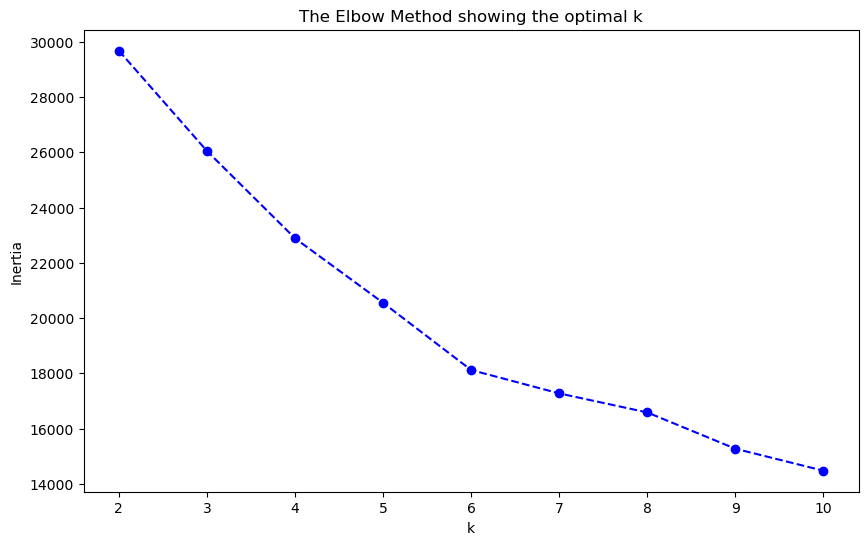

In [25]:
elbow_vis(df_cluster)

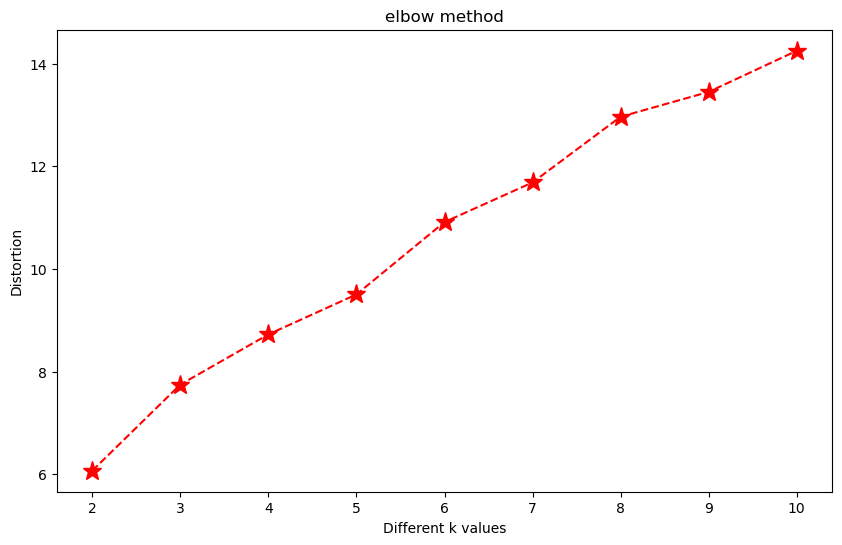

In [27]:
elbow_vis(df_cluster, inertia=False)

In [29]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 11)
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_cluster)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg = silhouette_score(df_cluster, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.36889373166705436
For n_clusters=3, the silhouette score is 0.2854258030402855
For n_clusters=4, the silhouette score is 0.19414211033152004
For n_clusters=5, the silhouette score is 0.20192793115222152
For n_clusters=6, the silhouette score is 0.2124425632894201
For n_clusters=7, the silhouette score is 0.19378269923210376
For n_clusters=8, the silhouette score is 0.1772969167314799
For n_clusters=9, the silhouette score is 0.1980953687847632
For n_clusters=10, the silhouette score is 0.20609864928216215


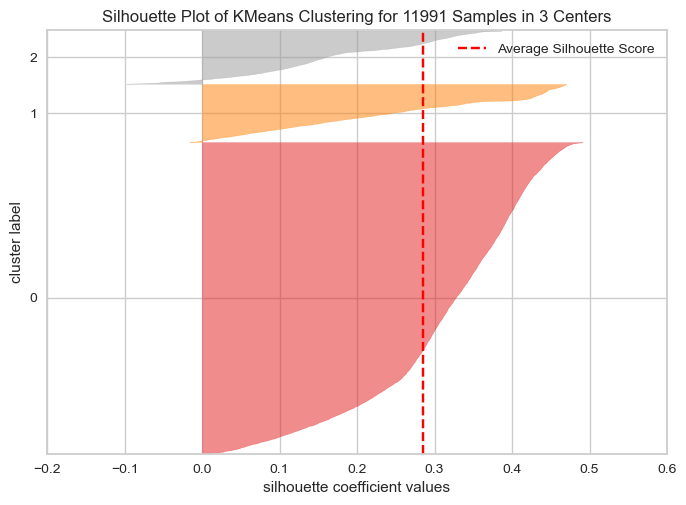

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer

model3 = KMeans(n_clusters=3, random_state=42)
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(df_cluster)  # Fit the data to the visualizer
visualizer.poof();

In [33]:
for i in range(model3.n_clusters):
    label = model3.labels_ == i
    print(
        f"mean silhouette score for label {i:<4} : {visualizer.silhouette_samples_[label].mean()}"
    )
print(f"mean silhouette score for all labels : {visualizer.silhouette_score_}")

mean silhouette score for label 0    : 0.3116595910127093
mean silhouette score for label 1    : 0.24816874735514313
mean silhouette score for label 2    : 0.17224217740418146
mean silhouette score for all labels : 0.2854258030402855


In [35]:
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit_predict(df_cluster)

array([0, 2, 1, ..., 2, 2, 0], dtype=int32)

In [37]:
df2['kmeans_labels'] = kmeans.labels_

In [39]:
clus_pred = df2.groupby("kmeans_labels").mean()
clus_pred

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,salary
kmeans_labels,,,,,,
0,0.685831,0.697455,3.513290,193.255853,2.770840,1.354145
1,0.281414,0.769634,5.065814,228.779403,4.142596,1.358927
2,0.679258,0.771750,4.125911,211.978794,5.999337,1.365142


In [41]:
from sklearn.preprocessing import MinMaxScaler

clus_pred_scaled = MinMaxScaler().set_output(transform="pandas").fit_transform(clus_pred)
clus_pred_scaled

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,salary
kmeans_labels,,,,,,
0,1.000000,0.00000,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.97153,1.000000,1.000000,0.42489,0.434847
2,0.983747,1.00000,0.394597,0.527057,1.00000,1.000000


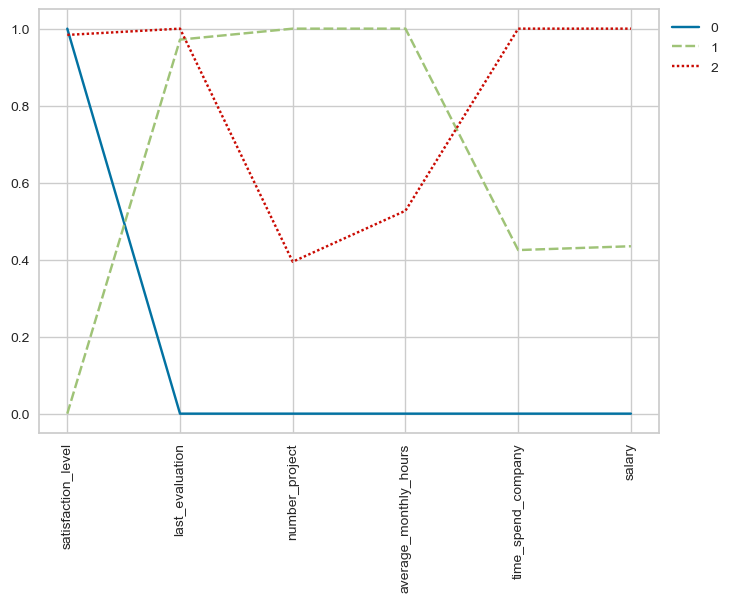

In [43]:
sns.lineplot(data=clus_pred_scaled.T)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=90);

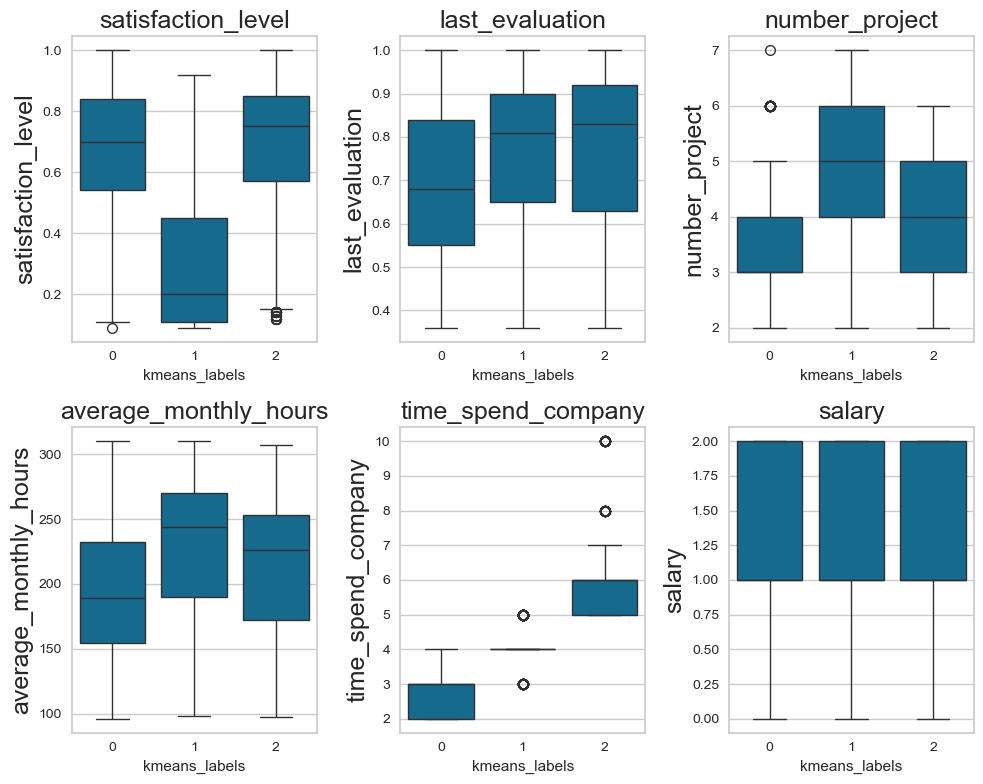

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes_flat = axes.flatten() 

for i, feature in enumerate(df2.columns[:-1]):
    ax = axes_flat[i]
    sns.boxplot(y=feature, x="kmeans_labels", data=df2, ax=ax)
    ax.set_ylabel(feature, fontsize=18)
    ax.set_title(feature, fontsize=18) 

plt.tight_layout()
plt.show()

In [47]:
selection = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company']

df_selected = df2[selection]

In [49]:
df_selected = scaler_cluster.fit_transform(df_selected)

In [51]:
result = []
for _ in range(10):
    result.append(hopkins(df_selected, 0.05))

np.mean(result)

0.8131750759480886

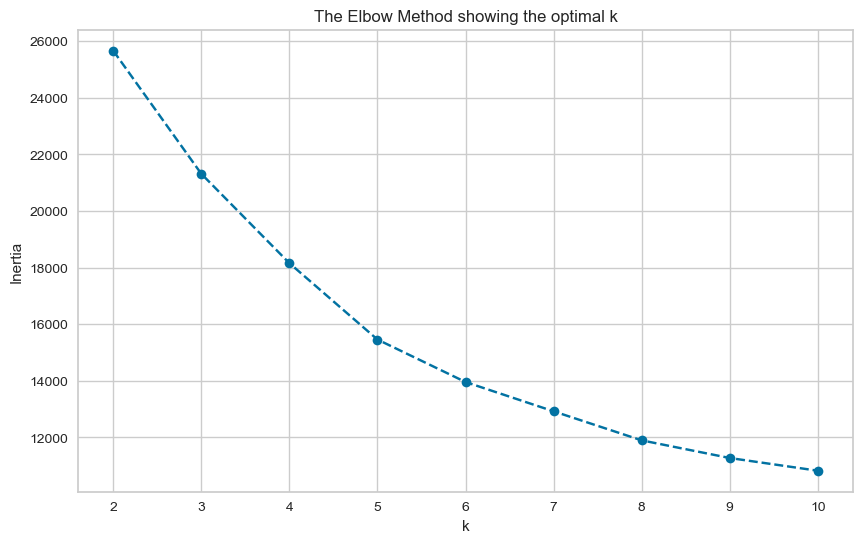

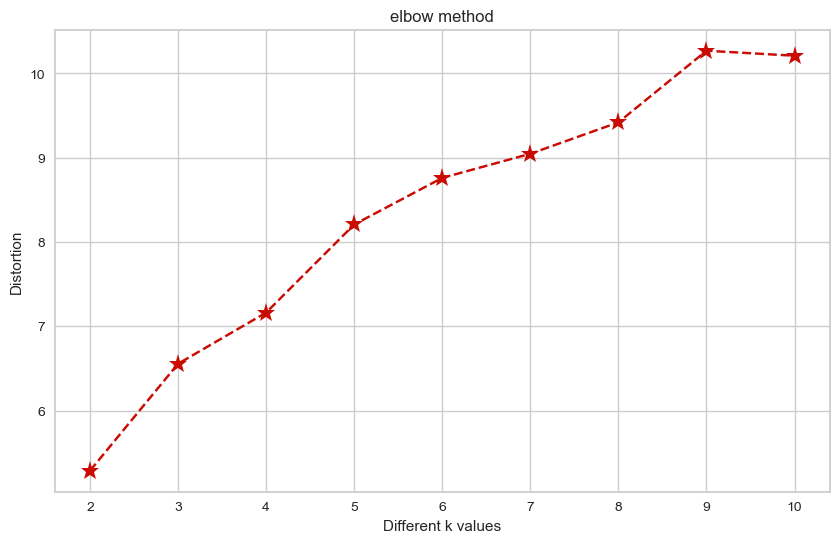

In [53]:
elbow_vis(df_selected)
elbow_vis(df_selected, inertia=False)

In [55]:
range_n_clusters = range(2, 9)
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_selected)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg = silhouette_score(df_selected, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.4328662000248689
For n_clusters=3, the silhouette score is 0.3271990042475274
For n_clusters=4, the silhouette score is 0.23435613599218016
For n_clusters=5, the silhouette score is 0.2560500815742779
For n_clusters=6, the silhouette score is 0.24333808087291592
For n_clusters=7, the silhouette score is 0.2249695411775279
For n_clusters=8, the silhouette score is 0.2244096440415325


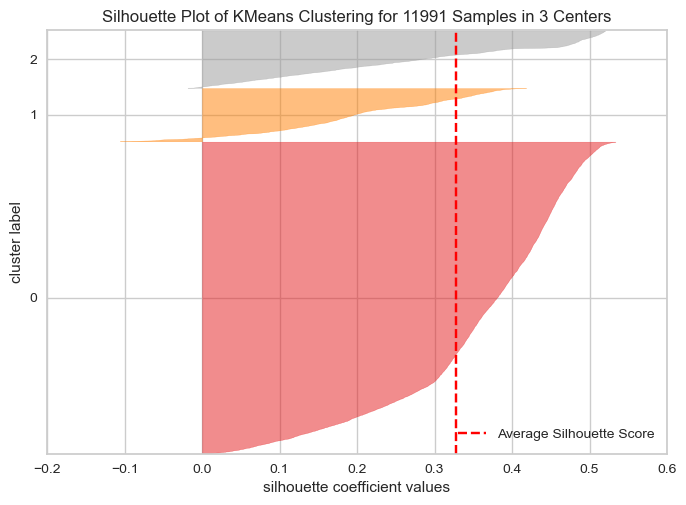

In [57]:
model3 = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(df_selected)  # Fit the data to the visualizer
visualizer.poof();

In [59]:
for i in range(model3.n_clusters):
    label = model3.labels_ == i
    print(
        f"mean silhouette score for label {i:<4} : {visualizer.silhouette_samples_[label].mean()}"
    )
print(f"mean silhouette score for all labels : {visualizer.silhouette_score_}")

mean silhouette score for label 0    : 0.3572371256998449
mean silhouette score for label 1    : 0.19862048327962264
mean silhouette score for label 2    : 0.28302692395244133
mean silhouette score for all labels : 0.3271990042475274


In [61]:
final_model = KMeans(n_clusters=3, random_state=42)
final_model.fit_predict(df_selected)

array([0, 1, 2, ..., 1, 1, 0], dtype=int32)

In [63]:
df['labels'] = final_model.labels_

In [65]:
df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary,labels
0,0.38,0.53,2,157,3,0,1,0,sales,low,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2
3,0.72,0.87,5,223,5,0,1,0,sales,low,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0
...,...,...,...,...,...,...,...,...,...,...,...
11986,0.90,0.55,3,259,10,1,0,1,management,high,1
11987,0.74,0.95,5,266,10,0,0,1,management,high,1
11988,0.85,0.54,3,185,10,0,0,1,management,high,1
11989,0.33,0.65,3,172,10,0,0,1,marketing,high,1


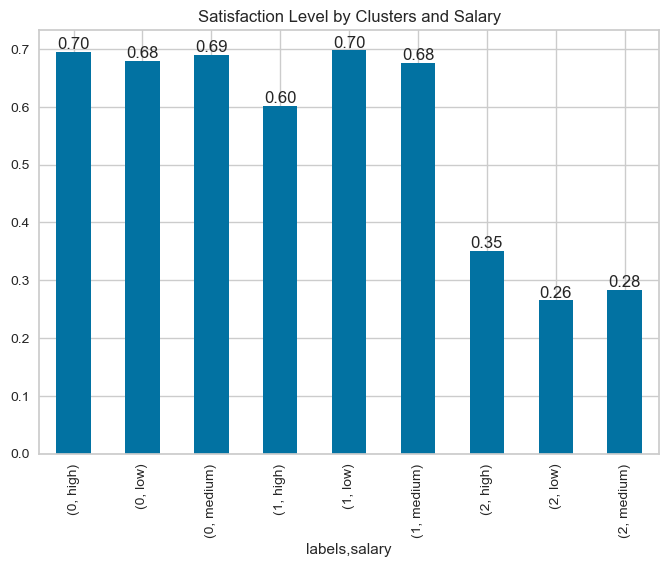

In [71]:
ax = df.groupby(['labels', 'salary'])['satisfaction_level'].mean().plot(kind='bar', title='Satisfaction Level by Clusters and Salary')
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

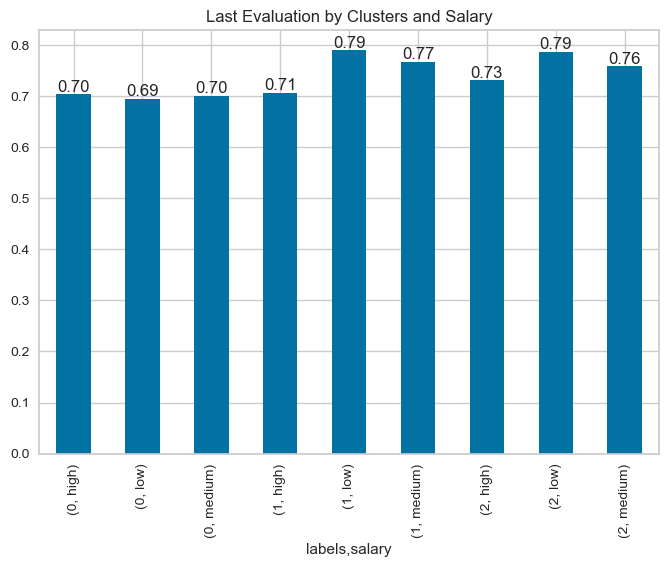

In [73]:
ax = df.groupby(['labels', 'salary'])['last_evaluation'].mean().plot(kind='bar', title='Last Evaluation by Clusters and Salary')
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

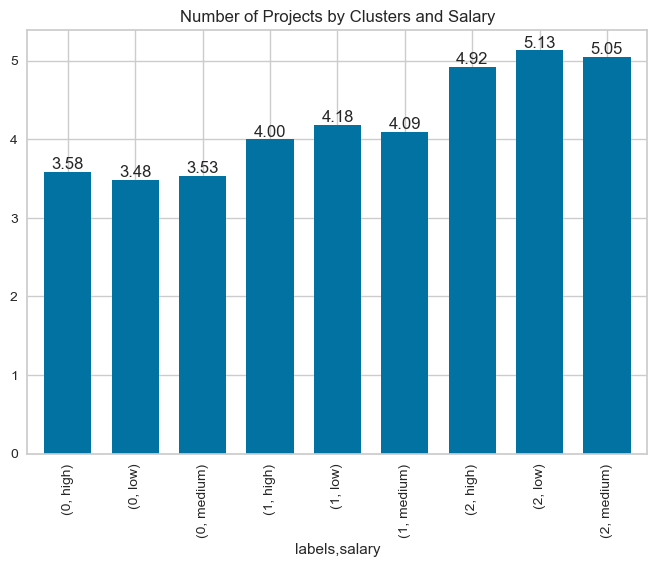

In [105]:
ax = df.groupby(['labels', 'salary'])['number_project'].mean().plot(kind='bar', title='Number of Projects by Clusters and Salary', width=0.7)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

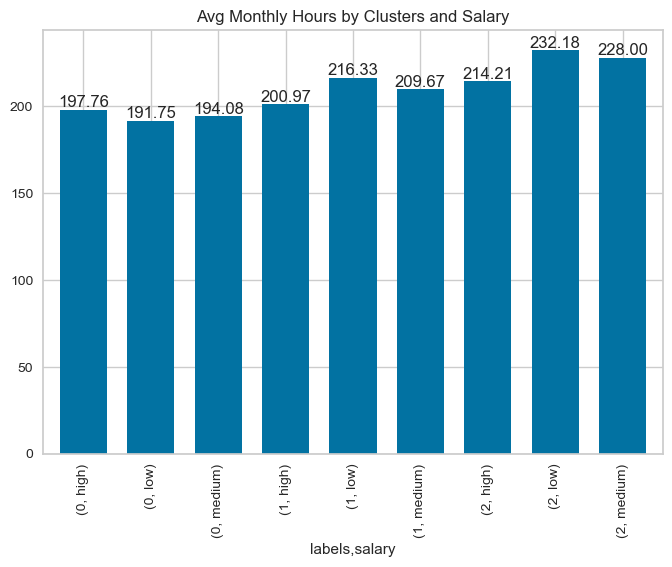

In [107]:
ax = df.groupby(['labels', 'salary'])['average_monthly_hours'].mean().plot(kind='bar', title='Avg Monthly Hours by Clusters and Salary', width=.7)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

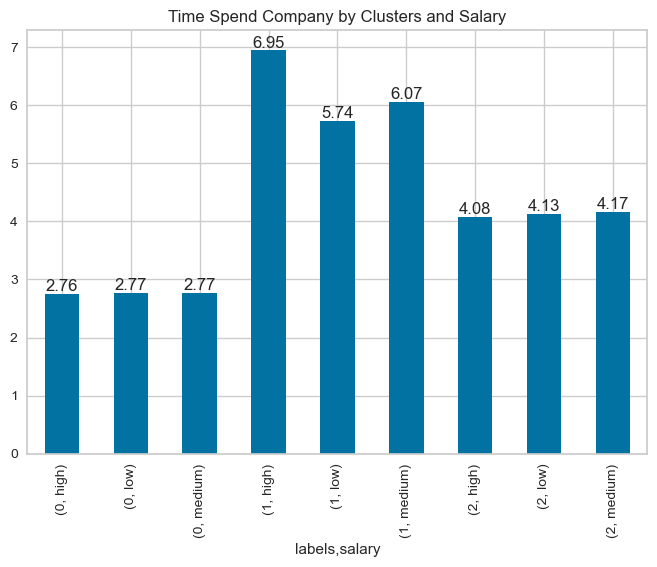

In [109]:
ax = df.groupby(['labels', 'salary'])['time_spend_company'].mean().plot(kind='bar', title='Time Spend Company by Clusters and Salary')
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

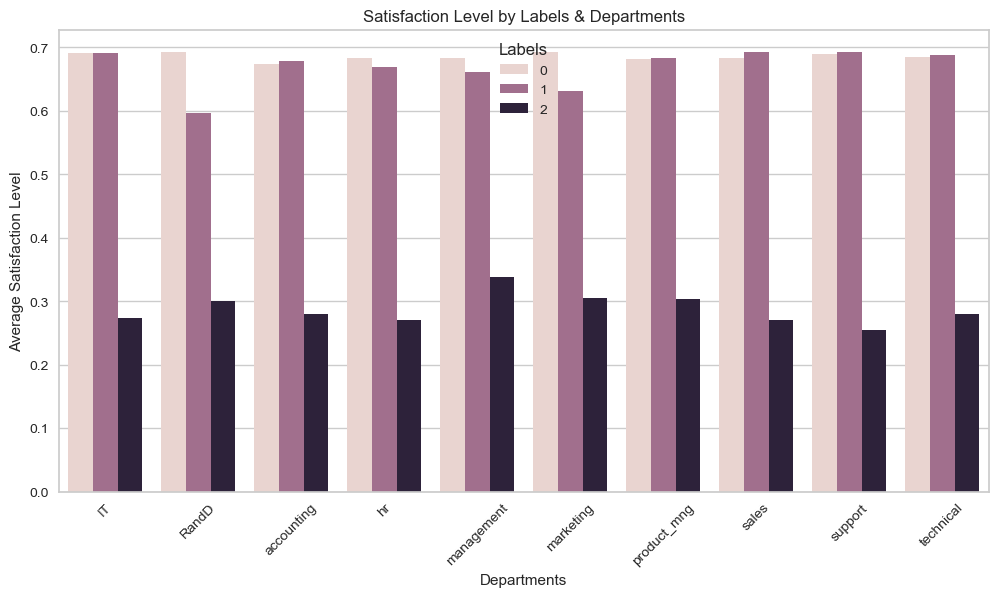

In [117]:
df_plot = df.groupby(['labels', 'departments'])['satisfaction_level'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, x='departments', y='satisfaction_level', hue='labels')

plt.xticks(rotation=45)
plt.title("Satisfaction Level by Labels & Departments")
plt.ylabel("Average Satisfaction Level")
plt.xlabel("Departments")
plt.legend(title="Labels")
plt.show()

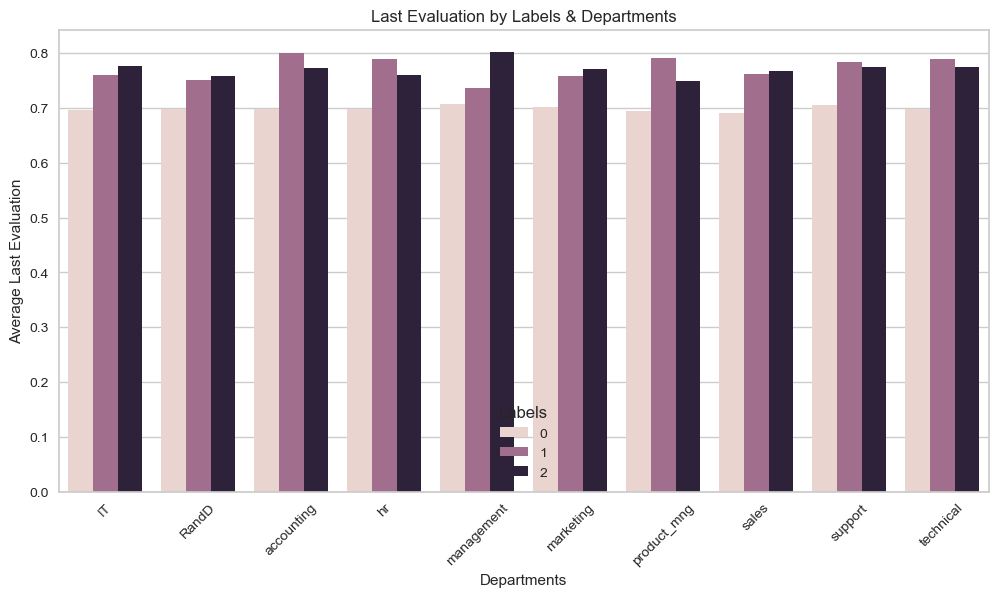

In [127]:
df_plot2 = df.groupby(['labels', 'departments'])['last_evaluation'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_plot2, x='departments', y='last_evaluation', hue='labels')

plt.xticks(rotation=45)
plt.title("Last Evaluation by Labels & Departments")
plt.ylabel("Average Last Evaluation")
plt.xlabel("Departments")
plt.legend(title="Labels")
plt.show()

In [129]:
pd.crosstab(df.labels, df.left, normalize='index')

left,0,1
labels,,
0,0.897471,0.102529
1,0.657181,0.342819
2,0.652094,0.347906


In [131]:
final_model2 = KMeans(n_clusters=2, random_state=42)
final_model2.fit_predict(df_selected)

array([0, 1, 0, ..., 1, 1, 0], dtype=int32)

In [133]:
df['labels2'] = final_model2.labels_

In [152]:
df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary,labels,labels2
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.90,0.55,3,259,10,1,0,1,management,high,1,1
11987,0.74,0.95,5,266,10,0,0,1,management,high,1,1
11988,0.85,0.54,3,185,10,0,0,1,management,high,1,1
11989,0.33,0.65,3,172,10,0,0,1,marketing,high,1,1


In [135]:
pd.crosstab(df.labels2, df.left, normalize='index')

left,0,1
labels2,,
0,0.861455,0.138545
1,0.686638,0.313362


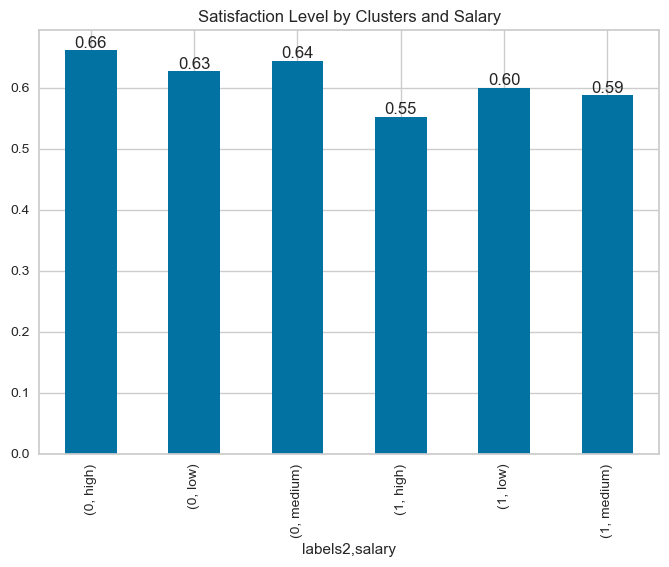

In [141]:
ax = df.groupby(['labels2', 'salary'])['satisfaction_level'].mean().plot(kind='bar', title='Satisfaction Level by Clusters and Salary')
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

## K-Modes Clustering

In [143]:
df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary,labels,labels2
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.90,0.55,3,259,10,1,0,1,management,high,1,1
11987,0.74,0.95,5,266,10,0,0,1,management,high,1,1
11988,0.85,0.54,3,185,10,0,0,1,management,high,1,1
11989,0.33,0.65,3,172,10,0,0,1,marketing,high,1,1


In [145]:
X = df.drop('left', axis=1).to_numpy()

In [147]:
categorical_columns = [5, 6, 7, 8]

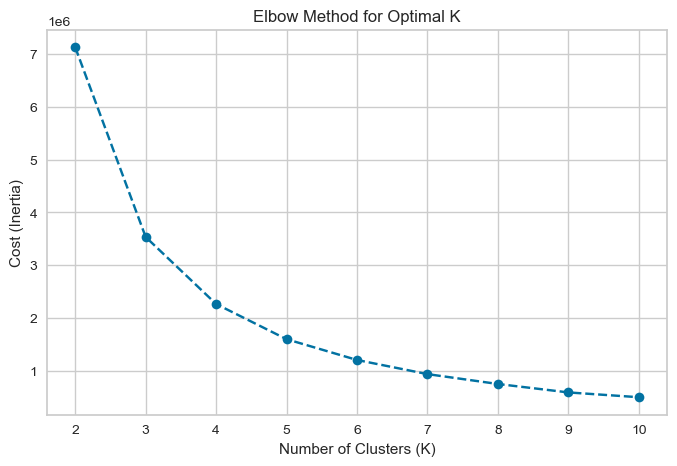

In [149]:
from kmodes.kprototypes import KPrototypes

def find_best_k(X, categorical_columns, max_clusters=10):
    costs = []
    K_range = range(2, max_clusters+1)  # Test from 2 to max_clusters

    for k in K_range:
        kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
        clusters = kproto.fit_predict(X, categorical=categorical_columns)
        costs.append(kproto.cost_)  # Store the cost for each k

    # Plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, costs, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Cost (Inertia)')
    plt.title('Elbow Method for Optimal K')
    plt.show()

find_best_k(X, categorical_columns)

In [151]:
kproto = KPrototypes(n_clusters=3, init='Huang', random_state=42)
clusters = kproto.fit_predict(X, categorical=categorical_columns)

In [153]:
df['clusters'] = clusters

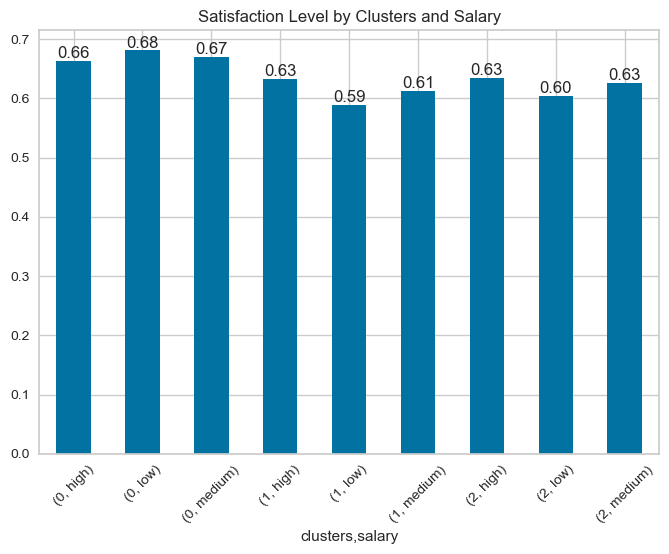

In [159]:
ax = df.groupby(['clusters', 'salary'])['satisfaction_level'].mean().plot(kind='bar', title='Satisfaction Level by Clusters and Salary')
plt.xticks(rotation=45)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

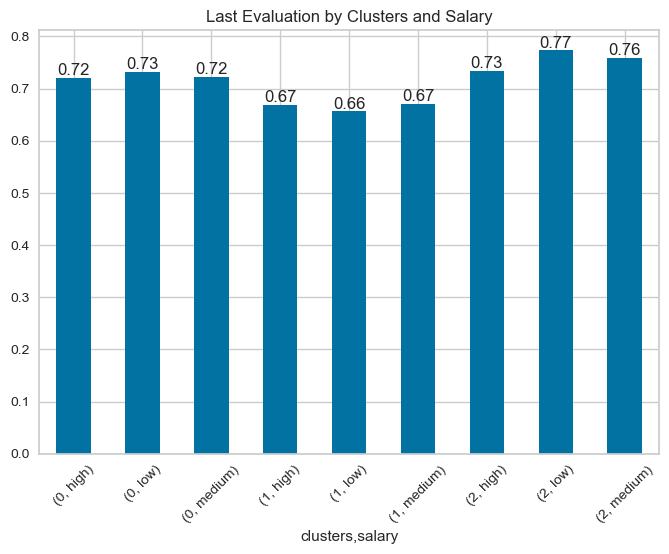

In [163]:
ax = df.groupby(['clusters', 'salary'])['last_evaluation'].mean().plot(kind='bar', title='Last Evaluation by Clusters and Salary')
plt.xticks(rotation=45)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

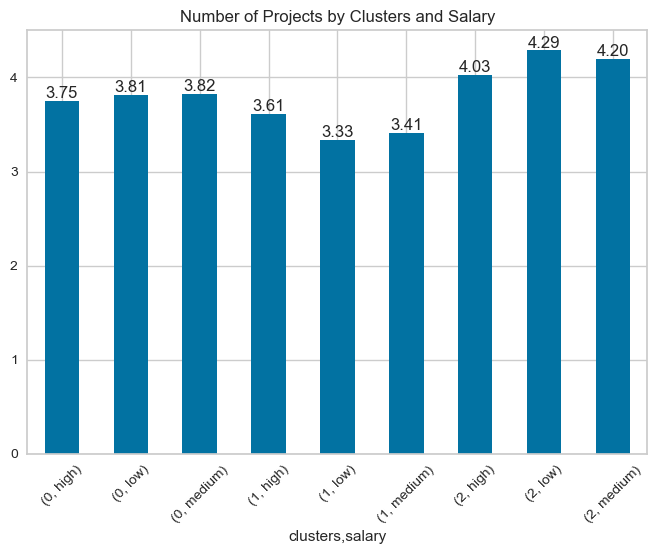

In [165]:
ax = df.groupby(['clusters', 'salary'])['number_project'].mean().plot(kind='bar', title='Number of Projects by Clusters and Salary')
plt.xticks(rotation=45)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

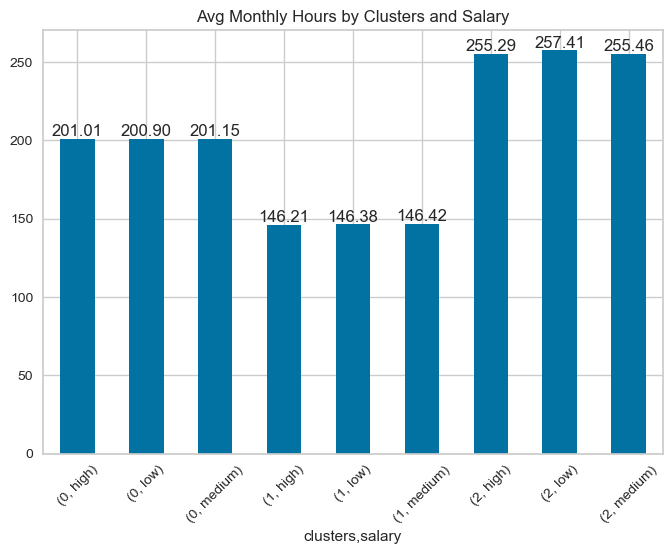

In [167]:
ax = df.groupby(['clusters', 'salary'])['average_monthly_hours'].mean().plot(kind='bar', title='Avg Monthly Hours by Clusters and Salary')
plt.xticks(rotation=45)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

In [169]:
data = df.groupby(['clusters', 'departments'], as_index=False)['satisfaction_level'].mean()

data['x'] = data.clusters.apply(lambda x: str(x)) + ', ' + data.departments

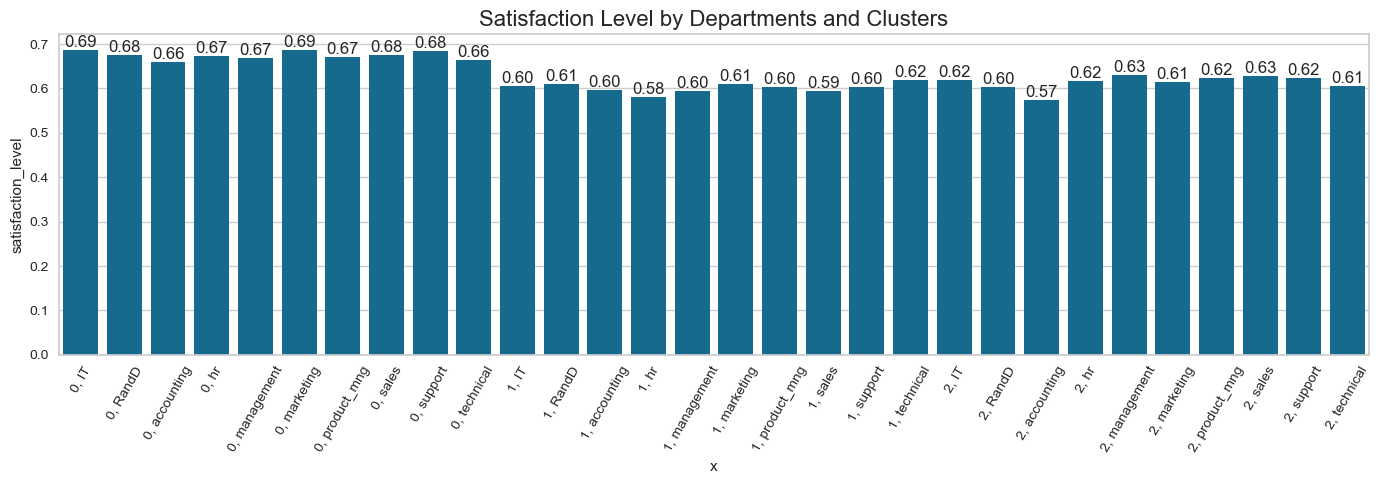

In [177]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=data, x='x', y='satisfaction_level')
plt.xticks(rotation=60)
plt.title('Satisfaction Level by Departments and Clusters', fontsize=16)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')
plt.tight_layout()
plt.show()

In [205]:
pd.crosstab(df.left, df.clusters, normalize='columns')

clusters,0,1,2
left,,,
0,0.964671,0.789972,0.760296
1,0.035329,0.210028,0.239704
